# 使用PyTorch编写卷积神经网络 

**王文中**

使用PyTorch开发卷积神经网络，一般需要导入以下模块：

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

## 使用PyTorch实现卷积网的基本运算

一个典型的卷积神经网络中主要包含了三类操作:卷积(Convolution)、池化(Pooling)、全连接(FC)，并且卷积与全连接层一般都会使用非线性响应函数(Activation Function)。

在PyTorch中，torch.nn实现了以上各种操作，它们对应的函数分别是：

- **卷积：```conv2d```**

  该函数有几个重要的参数，对应了卷积层的超参数：
  - in_channels:卷积层的输入层特征图的通道数
  - out_channels:卷积层输出的特征图通道数(即卷积核数目)
  - kernel_size:卷积核的大小
  - padding:输入特征图每边的填充量（填充值为0）。默认为padding=0，表明不扩充，对应VALID CONVOLUTION；padding=$\frac{kernel\_size-1}{2}$，对应SAME CONVOLUTION,输出的特征图的尺寸与输入特征图相同  
  - stride:跨度，通常为0(该参数的默认值为0)
  - bias:布尔型参数，False表示该层没有偏置参数，默认为True，表示该层有偏置参数

  例子：下面的代码定义了一个卷积操作，其中输入特征图的通道为16，输出通道数为32，卷积核大小为$3\times3$，使用VALID CONVOLUTION：
  ```python
  conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, bias=True)
  ```


- **池化:```MaxPool2d```,```AvgPool2d```**
  
  这两个函数的主要参数是kernel_size和stride,通常stride=kernel_size。

  例子：下面的代码定义了一个$2\times2$的最大池化操作：
  ```python
  pool = nn.MaxPool2d(kernel_size=2, stride=2)
  ```


- **全连接：```Linear```**
  
  该函数有三个参数，分别为：
  - in_features:表示输入特征的维数
  - out_features:表示输出特征的维数
  - bias:布尔型参数，False表示该层没有偏置参数，默认为True，表示该层有偏置参数
  
  例子：下面的代码定义了一个全连接层，输入与输出特征维数分别是128,256:
  ```python
  fc = nn.Linear(in_features=128, out_features=256, bias=True)
  ```
  
- **非线性响应函数**

  由torch.nn.functional提供，最常用的是```torch.nn.functional.relu```、```torch.nn.functional.sigmoid```、```torch.nn.functional.softmax```。其中第一个用作神经元的响应函数，后两个通常用作分类函数。



## 卷积与池化示例

下面的例子演示了卷积与池化运算。
卷积运算部分用Sobel边缘检测器对一幅3通道图像计算水平和竖直方向的边缘强度。
非线性运算采用Relu（请思考：对Sobel结果进行Relu运算的意义是什么？）。
池化运算使用了$2\times2$最大池化。

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

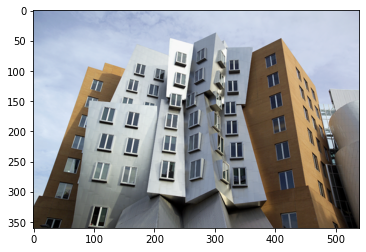

In [3]:
#读入图像
im = Image.open('Gates-Vassar.png')
im = np.array(im, dtype='float32') / 255.0

plt.imshow(im)

In [4]:
#把图像转换为pytorch Tensor，并调整为卷积层的维度要求，即卷积层输入的张量维度为(N,C,H,W)
#其中，N为图像张量的数量，C为通道数，H，W分别是图像的高度和宽度
print(im.shape)
im = torch.from_numpy(np.transpose(im, (2, 0, 1)))
im.unsqueeze_(0)
print(im.shape)

(360, 540, 3)
torch.Size([1, 3, 360, 540])


In [5]:
#定义水平方向的Sobel算子
sobel_x = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]).astype(dtype='float32')
sobel_x = np.reshape(sobel_x, (1, 3, 3))
print(sobel_x.shape)
print(sobel_x)

(1, 3, 3)
[[[-1.  0.  1.]
  [-2.  0.  2.]
  [-1.  0.  1.]]]


In [6]:
#定义竖直方向的Sobel算子
sobel_y = np.array([[-1.0, -2.0, -1.0], [0.0, 0.0, 0.0], [1.0, 2.0, 1.0]]).astype(dtype='float32')
sobel_y = np.reshape(sobel_y, (1, 3, 3))
print(sobel_y.shape)
print(sobel_y)

(1, 3, 3)
[[[-1. -2. -1.]
  [ 0.  0.  0.]
  [ 1.  2.  1.]]]


In [7]:
#把水平和竖直方向的Sobel算子拼接为(Out,In,KH,KW)的阵列
#其中Out=2为卷积层输出通道数目(即卷积核的数目，本例中为2,表示有两个卷积核Sobel_x,Sobel_y)
#In=3为卷积层输入图像的通道数目(本例中输入图像是RGB三通道图像，因此In=3)
#KH，KW是卷积核的大小，本例为3
sobel3d = np.concatenate(
    (np.repeat(sobel_x, 3, axis=0).reshape((1, 3, 3, 3)),
     np.repeat(sobel_y, 3, axis=0).reshape((1, 3, 3, 3))), 
    axis=0)
print(sobel3d.shape)

(2, 3, 3, 3)


In [8]:
#定义一个卷积操作，并设置该卷积操作的参数为Sobel_3d:
#注意，卷积操作的参数设置要与Sobel3d匹配
conv = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, padding=1, stride=[1, 1], bias=False)
conv.weight.data = torch.from_numpy(sobel3d)

torch.Size([1, 2, 360, 540])


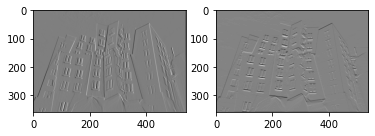

In [9]:
#用卷积操作对图像进行卷积：
edge = conv(im).data
print(edge.shape)
#分别获取水平和竖直方向的边缘响应
edge_x = edge[0, 0, :, :].squeeze().numpy()
edge_y = edge[0, 1, :, :].squeeze().numpy()

plt.subplot(1, 2, 1)
plt.imshow(edge_x, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edge_y, cmap='gray')

In [ ]:
#使用非线性响应函数ReLU:
#注意显示的图像与上图的区别
edge = F.relu(edge)
edge_x = edge[0, 0, :, :].squeeze().numpy()
edge_y = edge[0, 1, :, :].squeeze().numpy()

plt.subplot(1, 2, 1)
plt.imshow(edge_x, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edge_y, cmap='gray')

In [ ]:
#使用最大池化操作：
pool = nn.MaxPool2d(kernel_size=2, stride=2)
edge = pool(edge)

#注意池化后的edge大小的变化
print(edge.shape)

edge_x = edge[0, 0, :, :].squeeze().numpy()
edge_y = edge[0, 1, :, :].squeeze().numpy()

plt.subplot(1, 2, 1)
plt.imshow(edge_x, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(edge_y, cmap='gray')

## 编写简单的卷积神经网络

利用上一节介绍的运算，可以构建一个简单的卷积神经网络。

要创建一个神经网络，需要从nn.Module派生出一个子类，并实现该子类的初始化方法以及前向传播方法。PyTorch通过自动求导(AutoGrad)机制实现后向传播。

下面的代码实现了一个简单的卷积神经网络，这个网络的输入为$28\times28$的彩色图像(CIFAR10)，输出为10个类别：

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        #注意：首先调用父类的初始化函数
        super(CNN, self).__init__()
        
        #定义卷积、池化以及全连接操作
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #在前向函数中构造出卷积网络
        #注意这里的x把不同层连接起来
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.conv3(x)
        
        #使用torch.Tensor.view函数，把一个多维张量拉直为一个1维张量（向量）
        x = x.view(-1, 128)
        
        #全连接层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 训练神经网络

### 准备训练样本

训练神经网络需要先准备好训练数据，卷积网的训练数据通常都是图像数据，torchvision模块提供了很多常见的图像数据库的封装，比如MNIST，CIFAR，IMAGENET等，这些标准数据库都定义为torchvision.datasets模块中的类，比如MNIST数据集对应于torchvision.datasets.MNIST类。

- 构造图像数据集

除了这些标准数据集之外，也可以使用torchvision.datasets.ImageFolder类构造图像数据集。

构造自己的图像数据集时，需要把图像按照不同类别放入不同目录中。比如：'dog'类别的图像都放入到'dog'目录，'cat'类别的图像都放入'cat'目录。'cat','dog'目录都放入到'data'目录。如下所示：

      data/dog/0001.jpg
      data/dog/0002.jpg
      data/dog/harris.png
      ......
      data/cat/0001.png
      data/cat/ricky.png
      data/cat/adam_1.png
      ......
      
下面的代码定义了一个数据集，该数据集中的数据位于目录'./data'中，并且按照以上方式组织。

```python
data_set = torchvision.datasets.ImageFolder(root='./data')
```


- 定义数据变换

在卷积网络的训练中，通常会对图像数据做预处理和各种变换，比如对图像像素值做规一化、图像翻转、裁剪等等。
除此之外，在PyTorch中，图像数据要转换为torch.Tensor才能输入到网络中。

torchvision.transforms模块提供了大量图像变换的类和函数。常见的有：

   ```torchvision.transforms.ToTensor```，把一个PIL图像或numpy.ndarray转换为torch.Tensor
  
   ```torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)```，对PIL图像的亮度、对比度、饱和度以及色调进行随机扰动。
  
   ```torchvision.transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')```，对图像进行随机裁剪，裁剪后的图像大小由参数```size```确定。
  
   ```torchvision.transforms.RandomHorizontalFlip(p=0.5)```，根据指定的概率```p```随机对图像做左右翻转
  
   ```torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)```，根据指定的缩放系数范围scale和长宽比例范围ratio，对图像进行随机缩放和比例变换，然后随机裁剪为一幅size大小的图像。
  
   ```torchvision.transforms.Resize(size, interpolation=2)```，对图像进行缩放，缩放后的尺寸为size。这是最常用的图像变换，因为卷积网络的输入图像大小是恒定的，因此所有图像样本都必须要缩放到符合网络的输入尺寸。
  
   ```torchvision.transforms.Normalize(mean, std, inplace=False)```，对一个**张量**进行规范化处理，这里的两个参数分别表示均值和标准差。
  
除了以上变换之外，torchvision.transforms还提供了一个类Compose，可以把多个变换组合在一起。

下面定义一个数据变换，它由随机缩放裁剪、随机水平翻转以及规范化等变换组合而成：

```python
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),#把图像变换为张量
        normalize,#注意规范化要在ToTensor之后
    ])
```

如果需要对图像数据做变换，那就在构造数据集对象时指定初始化参数```transform```的值。下面的代码构造了一个数据集对象data_set，使用了上面定义的数据变换。

```python
data_set = torchvision.datasets.ImageFolder(root='./data', transform=data_transform)
```

- 构造数据加载器

```torch.utils.data.DataLoader```类是一个数据加载器类，实现了对数据集进行随机采样和多轮次迭代的功能。

在网络训练过程中，借助这个加载器可以非常方便的实现多轮次小批量梯度随机梯度下降训练。下面的代码构造了一个数据加载器，用于加载上面定义的数据集```data_set```，并指定batch_size为32，其中参数```shuffle=True```表明每一个轮次之前都会对数据做随机排列，这在随机梯度下降法中是必要的：

```python
data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                           batch_size=32,
                                           shuffle=True)
```

### 训练网络参数

- 定义损失函数

```torch.nn```模块中定义了很多标准的损失函数。下面的代码定义了一个交叉熵损失函数对象：

```python
xentropy = nn.CrossEntropyLoss()
```

损失函数对象有一个重要的方法：```backward()```，该方法是使用BP算法训练网络参数的关键，通过这个方法实现了误差反向传播。


假设网络的输出为```outputs```，真实类标为```labels```，下面的代码计算了两者之间的损失函数值，然后把误差反向传播：

```python
loss = xentropy(outputs, labels)
loss.backward()
```

- 定义优化器

```torch.optim```模块提供了很多优化算法类，比如：```torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop```。

构造优化器对象有两个重要参数，一个是优化变量，另一个是学习率。下面的代码构造了一个SGD优化器，用于优化前面定义的CNN网络模型的参数，设置学习率为0.01，动量参数为0.9：

```python
net = CNN()#构造一个CNN对象
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)
```

优化器的方法```step()```用于执行一步梯度下降，更新模型参数。


- 优化过程

神经网络训练过程的一步迭代包含四个主要步骤：1）前向运算，计算给定输入的预测结果；2）计算损失函数值；3）后向传播(BP)，计算参数梯度；4）使用梯度下降法更新参数值。

在PyTorch中，参数的梯度由变量维护，在每一步计算梯度之前应该先把前一步计算的梯度清除掉(调用优化器的```zero_grad()```函数)。下面的代码演示了一步迭代过程：

```python
#(inputs,labels)为训练样本

#0)首先要把前一步的梯度清除，即设置梯度值为0：
optimizer.zero_grad()

#1)前向运算，计算网络在inputs上的输出outputs
outputs = net(intputs)

#2)计算损失函数值
loss = xentropy(outputs, labels)

#3)后向传播，计算梯度
loss.backward()

#4)梯度下降，更新模型参数
optimizer.step()

```


- 完整的训练代码

下面的函数```train```实现了模型训练的完整过程。

注意：训练模型之前需要调用模型的train()函数，进入训练模式。通过调用模型和数据张量的to函数，实现在指定的设备(GPU、CPU)上训练。

In [ ]:
def train(net, optimizer, loss_fn, num_epoch, data_loader, device):
    net.train()#进入训练模式
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        for i, data in enumerate(data_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print('[%d, %5d] loss = %.3f' % (epoch+1, i+1, running_loss/100))
                running_loss = 0.0

- 完整的测试代码

测试模型的精度时，需要调用模型的eval()函数，进入评估模式。

下面的函数evaluate实现了完整的模型测试过程，函数返回分类准确率。

In [ ]:
def evaluate(net, data_loader, device):
    net.eval()#进入模型评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    return acc

### 实例：CIFAR10图像分类

下面利用上一小节构造的网络CNN，对CIFAR10图像进行分类。

下面的代码演示了使用CIFAR10对网络进行训练和测试的过程：

In [ ]:
def main():
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_set = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform)
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=2)

    device = torch.device("cuda:0")

    net = CNN()
    net.to(device)

    xentropy = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001)
    num_epoch = 20

    train(net=net,
          optimizer=optimizer,
          loss_fn=xentropy,
          num_epoch=num_epoch,
          data_loader=train_loader,
          device=device)

    train_acc = evaluate(net=net,
                         data_loader=train_loader,
                         device=device)

    test_acc = evaluate(net=net,
                        data_loader=test_loader,
                        device=device)
    print('Training Accuracy: %.2f %%' % (100 * train_acc))
    print('Test Accuracy: %.2f %%' % (100 * test_acc))


if __name__ == '__main__':
    main()

### 保存与加载模型

模型优化好之后，通常要把模型参数保存下来以便后续使用。

PyTorch推荐的保存模型的方法是保存状态词典(state_dict)，状态词典是网络模型每一层到对应参数张量的映射，通过调用```nn.Module```类的方法```state_dict()```获得模型的状态词典。

下面的代码输出了前面定义的网络CNN的状态词典中每个参数张量的名称和大小：

In [ ]:
model = CNN()
state_dict = model.state_dict()
print('State_dict of CNN model:')
for param_tensor in state_dict:
    print(param_tensor, '\t', state_dict[param_tensor].size())

状态词典的保存和加载分别由```torch.save()```和```torch.load()```实现。状态词典通常保存为一个.pth文件。

如果要使用已经保存的模型参数继续训练模型或者对新的数据做预测，需要调用模型的```load_state_dict()```函数把从磁盘文件中读入的状态词典加载到模型中。

下面的代码演示了保存和加载状态词典到一个模型中：

```python
model = CNN()
#训练模型......

#保存训练好的参数到文件my_model.pth中
state_dict = model.state_dict()
torch.save(state_dict,'my_model.pth')

#使用保存的模型参数：
state_dict = torch.load('my_model.pth')
#把读入的模型参数加载到模型model中：
model.load_state_dict(state_dict)

```

# 使用预训练模型

卷积神经网络在图像识别、图像分割等领域取得了非常大的成功，出现了很多非常好的网络模型，比如ResNet、GoogLeNet等图像分类模型、Faster RCNN、YOLO等目标检测模型。

在使用卷积网络解决我们自己遇到的图像识别任务时，通常先用这些优秀的模型作为基准，再针对自己所处理的识别问题的特点做有针对性的修改和设计，因为从0开始设计一个全新的网络结构并且能取得非常好的效果是很困难的。

torchvision.models模块中给出了很多优秀的卷积网络的定义，比如VGG、ResNet、SqueezeNet、DenseNet、Inception、GoogLeNet、MobileNet等。这些模型都有对应的类，可以通过类的构造函数创建相应的模型。如下面代码所示(https://pytorch.org/docs/stable/torchvision/models.html )：

```python
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet = models.mobilenet_v2()
resnext50_32x4d = models.resnext50_32x4d()
```

PyTorch的Model Zoo中还提供了这些模型在ImageNet等数据集上训练得到的权值参数。如果要使用这些预训练的参数，只需要在模型类的构造函数中指定参数```pretrained```值为```True```。在加载模型时，会从指定的网址下载模型参数(.pth文件)。

下面的代码使用预训练权值创建了一个ResNet50模型：

```python
resnet50 = models.resnet50(pretrained=True)
```

如果本地已经下载了权值pth文件，也可以在创建模型时，指定```pretrained=False```(默认参数)，然后从本地磁盘文件中加载状态词典文件，并加载到模型中。如下面代码所示：

```python
resnet50 = models.resnet50()
#使用本地磁盘上的模型参数文件
state_dict = torch.load('resnet50.pth')
#把读入的模型参数加载到模型model中：
resnet50.load_state_dict(state_dict)
```

**使用预训练模型时要注意对输入图像做指定的规一化操作，在ImageNet上训练的模型，大部分输入图像的大小是$224\times224\times3$，并且要转换为（$3\times224\times224$）形状的张量。图像的像素值做规一化，均值与标准差分别为```mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]```**。

下面的代码定义了这个标准化操作：

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

## 使用预训练模型解决新的图像识别问题

面对一个新的图像识别任务，常见的做法是使用ImageNet上训练的模型做迁移学习：即使用已经训练好的模型，把最后的分类层(Softmax)改造为新的分类层，用新的图像数据做进一步训练，得到一个针对新任务的识别模型。

根据新任务中训练样本数量的多少，又可以分为以下三种迁移方式（以ResNet为例）：

1. 数据量非常少（比如每个类别只有几十张图像）：
   
   用ResNet做为特征提取器，只用新数据训练Softmax层分类器。
   
   
2. 数据量比较少（比如总数据量比较少，只有几千张图像）：
   
   固定ResNet低层网络权值，用新数据训练高层权值，并且使用预训练的权值初始化高层权值。
   
   
3. 数据量比较大：

   用预训练权值初始化整个网络，然后用新的数据微调全部参数。
   
下面以花卉识别为例，介绍如何使用上面三种方式把ImageNet数据集上训练的ResNet50模型迁移到花卉识别任务上。

我们使用OxfordFlower102数据集，该数据集中有102种不同的花卉，每一种花卉有几十张图像。

下面的代码构造了训练集与测试集的数据加载器：

In [ ]:
train_dir = './data/OxfordFlowers102/train'
val_dir = './data/OxfordFlowers102/val'
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_set = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

test_set = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

接下来，构造一个ResNet50模型，并且使用本地磁盘上的预训练权值参数：

In [ ]:
net = models.resnet50(pretrained=False)
state_dict = torch.load('./model/resnet50.pth')
net.load_state_dict(state_dict=state_dict)

### 使用ResNet50作为特征提取器

这种情况下，完全不需要训练模型各个层的参数。只需要把各个参数的属性```requires_grad```设置为```False```即可。如下方代码所示：

In [ ]:
for param in net.parameters():
    param.requires_grad=False

### 部分微调ResNet50

这种情况下，我们对ResNet50的高层参数做微调，因此，只需要把低层参数的的属性```requires_grad```设置为```False```即可。

下面的代码列出了网络的各个层参数名称：

In [ ]:
for name, _ in net.named_parameters():
    print(name)

假设只需要训练layer4的权值，那么可以把layer1~layer3的参数的梯度属性置为False，如下方代码所示：

In [ ]:
exclude_layers = ['layer1', 'layer2', 'layer3']#这些层不训练
for name, param in net.named_parameters():
    for layer in exclude_layers:
        if name.startswith(layer):
            param.requires_grad = False
            break

### 微调全部参数

这种情况不需要做特殊处理，net的各层参数的```requires_grad```属性默认为```True```。

### 改造分类层

原始ResNet模型是用于对ImageNet图像做分类的，分类层有1000个输出节点。在OxfordFlower102数据集上，要把这个分类层改造为输出102个节点。这只需要把原始网络中的FC层替换为新的全连接层即可，如下代码所示：

In [ ]:
num_classes = 102
featureSize = net.fc.in_features
net.fc = nn.Linear(featureSize, num_classes)

### 训练网络

网络的训练过程与前文一样。

## 分类结果分析

### 混淆矩阵

通常用识别精度（准确率）这单一数值来衡量模型的识别效果，但是识别精度不能反映不同类别之间的错分情况。因此，为了了解模型对不同类别的分类性能，还需要考查每一个类别的分类精度以及不同类别之间的错分情况。这时候可以通过观察混淆矩阵来发现模型的一些问题。

下面的代码定义了一个测试函数，用于评估一个模型的识别精度，并计算混淆矩阵。

假设有17个类别，混淆矩阵是一个$17\times 17$的矩阵$C$，$C[i,j]$表示第$i$类图像被识别为第$j$类的样本数目。

In [ ]:
from torchnet.meter import ConfusionMeter

def evalWithCM(net, data_loader):
    correct = 0
    total = 0
    cm = ConfusionMeter(17)#假定有17个类别，cm是一个17行17列的矩阵
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            cm.add(predicted, labels)

    acc = correct / total
    return acc, cm

下面是某个CNN在OxfordFlowers17训练集上得到的混淆矩阵，可以看出来，第3类(ColtsFoot)有很多(15个样本)被错分到了第6类(Daffodil),第6类有很多被错分到了第4类(Cowslip)，第8类(Dandelion)有很多被错分到了第2类(Buttercup)...通过分析这些被错分的样本，有可能找到模型、训练方式或样本存在的问题，并进行针对性的改进。

In [ ]:
[[47  0  0  0  3  0  0  0  0  4  1  3  2  0  0  0  0]
 [ 0 40  1 10  0  1  2  0  0  0  1  0  0  0  1  4  0]
 [ 0 11 14  5  0 15  1  2  0  0  0  0  2  3  1  5  1]
 [ 0  1  0 48  0  0  0  0  0  2  1  1  1  0  1  4  1]
 [ 1  0  1  0 40  0  7  0  0  0  1  4  4  0  0  1  1]
 [ 0 16  1 12  0 13  2  0  0  0  0  1  1  2  1 10  1]
 [ 0  0  0  0  0  0 51  0  0  0  2  0  0  0  0  0  7]
 [ 0 20  3  4  0  5  0 22  0  0  0  0  0  0  0  5  1]
 [ 0  0  0  0  0  0  0  0 49  1  0  0  4  0  4  0  2]
 [ 4  2  1  1  3  3  2  0  3 30  0  4  0  0  3  0  4]
 [ 1  0  0  2  0  0  1  0  0  2 38  0 14  0  0  0  2]
 [ 0  0  0  2  2  1  3  0  1  1  0 48  0  0  0  0  2]
 [ 0  0  0  2  3  0  3  0  0  0  1  0 44  0  0  1  6]
 [ 0  0  1  5  0  3  1  0  0  0  0  0  0 41  4  5  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0 55  3  1]
 [ 0  5  0 21  1  2  1  0  0  0  0  1  5  1  3 20  0]
 [ 0  0  0  0  0  0  5  0  1  0  3  0  0  0  0  0 51]]

## 编写复杂的网络结构

使用torch.nn模块，我们可以实现很多复杂的结构。

### ResBlock

ResNet中的一个基本结构是ResBlock，这是一个包含两个卷积层的小型卷积网络。每一个卷积层都是$3\times3$的卷积，并且padding=1，第一个卷积层的输入与第二个卷积层的输出相加之后，经过非线性变换得到整个Block的输出；卷积运算与非线性运算之间有BatchNormalizaiotn.

ResNet-18，ResNet-34这两个网络中，都包含了4组由这种Block组成的子结构(这里称为ResLayer)，每一组有2~3个ResBlock,除了第一组之外，每一组的第一个Block中的第一个卷积层采用stride=2，使得输出的特征图尺寸降到输入的一半。每一组的特征图通道数为前一组通道数的2倍，同一组内通道数不变。以ResNet-18为例，这四组的特征图通道数分别是64，128，256，512.最后一组输出的特征图经过全局平均池化，然后接入一个1000维的全连接层。

下面的代码分别实现了ResBlock，ResLayer，ResNet-18

In [ ]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels, downsample = False):
        super(ResBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,padding=1,stride = stride, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features = out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size = 3,padding=1,stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(num_features = out_channels)
        
        self.relu = nn.ReLU(inplace = True)

        self.downsample = downsample
        if downsample:
            self.sampling_conv = nn.Conv2d(in_channels, out_channels,kernel_size=1, stride = stride, padding = 0)
            self.sampling_bn = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x): 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = x
        if self.downsample:
            identity = self.sampling_conv(identity)
            identity = self.sampling_bn(identity)

        out += identity

        out = self.relu(out)
        return out

In [ ]:
class ResLayer(nn.Module):
    def __init__(self, in_channels, out_channels, n_blocks, downsample = True):
        super(ResLayer,self).__init__()
        blocks = [ResBlock(in_channels,out_channels,downsample)]
        for i in range(1,n_blocks):
            blocks.append(ResBlock(out_channels,out_channels))

        self.layer = nn.Sequential(*blocks)

    def forward(self,x):
        return self.layer(x)

In [ ]:
#ResNet-18
class MyResnet(nn.Module):
    def __init__(self, blocks):
        super(MyResnet,self).__init__()
        channels = 64
        self.conv1 = nn.Conv2d(3,channels,kernel_size = 7,padding = 3, stride = 2, bias = False)
        self.bn1 = nn.BatchNorm2d(num_features = channels)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.gPool = nn.AvgPool2d(kernel_size=7)
        
        self.layers = [ResLayer(in_channels=channels,out_channels=channels,n_blocks = blocks[0], downsample=False)]        

        for b in blocks[1:]:
            self.layers.append(ResLayer(in_channels=channels,out_channels=2*channels,n_blocks = b))
            channels = channels * 2
        self.lin = nn.Linear(in_features=channels,out_features=1000)


    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        for l in self.layers:
            x = l(x)
        x = self.gPool(x)
        x = x.view(-1,x.shape[1])
        x = self.lin(x)
        x = nn.Softmax(dim=1)(x)

        return x

下面读入一张图像，测试这个网络.

In [ ]:
import torch
resnet = MyResnet([2,2,2,2])

im = Image.open('Woolsthorpe-Manor.jpg')
im = im.resize((224,224))
im = np.array(im, dtype = np.float32) / 255.0
im_tensor = torch.from_numpy(im)
im_tensor = im_tensor.permute((2,0,1))
im_tensor = im_tensor.unsqueeze(dim=0)
print(im_tensor.size())

out = resnet(im_tensor)
print(out.size())